## IMPORTS

In [1]:
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import userdata
from statistics import mean

## Main function

In [2]:
def get_github_events(repo_url, api_key, recent_minutes):
    # Extract the repo owner and name from the privided URL
    repo_parts = repo_url.rstrip('/').split('/')
    repo_owner = repo_parts[-2]
    repo_name = repo_parts[-1]

    # Create the GitHub API URL
    events_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/events"

    # Calculate the time range relative to current time
    time_range = datetime.utcnow() - timedelta(minutes = recent_minutes)

    # Set up the headers with the API key for authorization
    headers = {
        "Authorization": f"token {api_key}"
    }

    # Make the API request
    response = requests.get(events_url, headers)

    # Check if the request was successful, return status code if not
    if response.status_code != 200:
        raise Exception(f"Error fetching events: {response.status_code}, {response.text}")

    events = response.json()
    filtered_events = []
    allowed_events = {'PushEvent', 'PullRequestEvent', 'IssueCommentEvent', 'WatchEvent'}

    # Filter events based on type and time and check if it is allowed event
    for event in events:
        event_type = event.get('type')
        event_time = datetime.strptime(event.get('created_at'), '%Y-%m-%dT%H:%M:%SZ')

        if event_type in allowed_events and event_time >= time_range:
            filtered_events.append(event)

    return filtered_events

## Tested repository

In [3]:
# TEST:
repo_url = "https://github.com/pandas-dev/pandas"
api_key = userdata.get('API_KEY') # generate and supply your own api key as I hid mine via properties
recent_minutes = 28800 # 20 days = 28 800 minutes
result = get_github_events(repo_url, api_key, recent_minutes) # call the function itself
print(result)

[{'id': '41584638207', 'type': 'IssueCommentEvent', 'actor': {'id': 71017186, 'login': 'mimistiv', 'display_login': 'mimistiv', 'gravatar_id': '', 'url': 'https://api.github.com/users/mimistiv', 'avatar_url': 'https://avatars.githubusercontent.com/u/71017186?'}, 'repo': {'id': 858127, 'name': 'pandas-dev/pandas', 'url': 'https://api.github.com/repos/pandas-dev/pandas'}, 'payload': {'action': 'created', 'issue': {'url': 'https://api.github.com/repos/pandas-dev/pandas/issues/59688', 'repository_url': 'https://api.github.com/repos/pandas-dev/pandas', 'labels_url': 'https://api.github.com/repos/pandas-dev/pandas/issues/59688/labels{/name}', 'comments_url': 'https://api.github.com/repos/pandas-dev/pandas/issues/59688/comments', 'events_url': 'https://api.github.com/repos/pandas-dev/pandas/issues/59688/events', 'html_url': 'https://github.com/pandas-dev/pandas/pull/59688', 'id': 2501397616, 'node_id': 'PR_kwDOAA0YD856L6YW', 'number': 59688, 'title': 'Fix docstring timestamps (Issue #59458)',

## Pandas initialization + file export

In [4]:
# Load the data to pandas dataframe
df = pd.DataFrame(result)

# Count the number of unique event types and the number of occurrences of each type (it's already filtered for the wanted types only)
event_type_counts = df['type'].value_counts()

data_output = ""
data_output += "# Events\n\n"
data_output += f"**Number of event types:**, {len(event_type_counts)}\n"
data_output += "**Occurrences of each event type:**\n"
data_output += event_type_counts.to_markdown()

with open('github_event_analysis.md', 'w') as file:
  file.write(data_output)


## Calculating averages

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])

# Calculate the average time between the same events
average_time_differences = {}
for event_type in df['type'].unique():
    # Filter events by type and calculate time differences
    event_times = df[df['type'] == event_type]['created_at'].sort_values()
    time_diffs = event_times.diff().dt.total_seconds().dropna()  # .dropna => drop the first NaN

    if len(time_diffs) > 0:  # Check if there are enough time differences to calculate > it will not crash if 0
        average_time_differences[event_type] = mean(time_diffs)
    else:
        average_time_differences[event_type] = None

# Calculate the average length of commits
commit_message_lengths = []
for index, row in df.iterrows():
    if row['type'] == 'PushEvent' and 'payload' in row and 'commits' in row['payload']:
        for commit in row['payload']['commits']:
            commit_message_lengths.append(len(commit['message']))

# Return average length, return 0 if no messages
if commit_message_lengths:
    average_commit_message_length = round(mean(commit_message_lengths))
else:
    average_commit_message_length = 0

# MD composition
averages_output = ""
averages_output += "# Averages"
averages_output += "Average time between events by type (in seconds):\n"

for event_type, avg_time in average_time_differences.items():
    averages_output += f" **{event_type}**: {avg_time} seconds\n"

averages_output += f"** Average commit message length** *(rounded to whole character)*:\n"
averages_output += f"{average_commit_message_length} characters"

with open('github_event_averages.md', 'w') as file:
  file.write(averages_output)

## Plotting

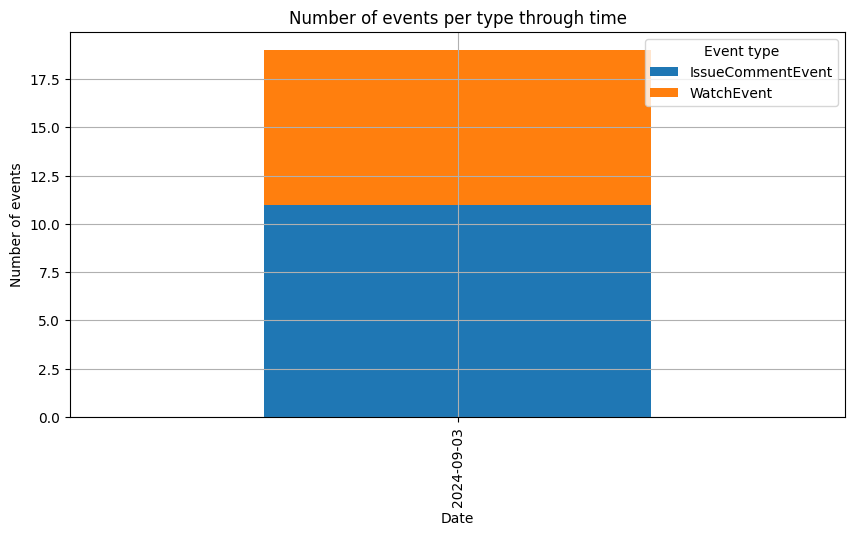

In [6]:
# Convert the created_at column to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

# Group the data by date and event type, and count the number of occurrences
df['date'] = df['created_at'].dt.date
event_counts_by_date = df.groupby(['date', 'type']).size().unstack().fillna(0)
event_counts_by_date.plot(kind='bar', stacked=True, figsize=(10, 5))


plt.title('Number of events per type through time')
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.legend(title='Event type')
plt.grid(True)

# Save the plot as image
plt.savefig("event_counts_by_date.png")
plt.show()

plot_output = ""
plot_output += "# GitHub Event Analysis\n\n"
plot_output += "## Number of events per type through time\n"
plot_output += "![Event counts by date](event_counts_by_date.png)\n\n"

with open('github_event_plot.md', 'w') as file:
    file.write(plot_output)

